### Online estimation of mean and standard deviation.

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from time import time
import math
import ipython_memory_usage as imu
imu.start_watching_memory()

In [2] used 0.0703 MiB RAM in 0.15s, peaked 0.00 MiB above current, total RAM usage 46.89 MiB
In [2] used -0.0156 MiB RAM in 0.26s, peaked 0.00 MiB above current, total RAM usage 46.87 MiB


##### Co-Routines

Co-routines are and extension of Generators. They are based on adding the commands 
`g.send(k)` which sends to the routine `g` the message `k`

The routine `g` waits for this message using the command

`input = (yield)`

A co-routine is very similar to a subroutine that does not return a value but has persitent local variables that remain between calls.

In [ ]:
## Example 1: generator
def countdown_gen(n):
    while n>0:
        yield n
        n-=1
[i for i in countdown(5)]

In [ ]:
## Example 2: co-routine
def countdown_co(n):
    while n>0:
        inp=(yield)
        print n,inp
        n-=1
a=countdown_co(5)
a.next()
for i in range(5):
    a.send(i)

#### A few comments on using co-routines

1. A co-routine has to be "primed", i.e. you have to start by sending it a `.next()` command. This tedious task is taken care of by the decorator `@coroutine` below.
2. To stop cleanly a co-routine has to send the exception `GeneratorExit`

In [8]:
# coroutine.py
#
# A decorator function that takes care of starting a coroutine
# automatically on call.

def coroutine(func):
    def start(*args,**kwargs):
        cr = func(*args,**kwargs)
        cr.next()
        return cr
    return start

# Example use
if __name__ == '__main__':
    @coroutine
    def grep(pattern):
        print "Looking for %s" % pattern
        while True:
            line = (yield)
            if pattern in line:
                print line,

    g = grep("python")
    # Notice how you don't need a next() call here
    g.send("Yeah, but no, but yeah, but no")
    g.send("A series of tubes")
    g.send("python generators rock!")
    print type(g)

Looking for python
python generators rock! <type 'generator'>


### Pipelines

for our work on online estimation we will combines several co-routines into a pipeline. Pipelines are a common way for constructing complex streaming algorithms from simple ones.

In [9]:
## A co-routine that acts as a sink - collects the items it recieves as input into a global-scope array
@coroutine
def collector(O):
    while True:
        item=(yield)
        O.append(item)


### Estimating the average

In [10]:
@coroutine
def av_filter(target,alpha=0):
    t=0; s=0
    while True:
        a=(yield) # wait here to be get something sent.
        if(alpha==0):  # regular average
            t+=1
            alpha_=1.0/t
            s=alpha_*a+(1-alpha_)*s
        else:  # Exponentially decaying average
            s=alpha*a+(1-alpha)*s
        r=a-s  # a: input, s/n: average, r: residual
        target.send((a,s,r))


In [11]:
sz=1000; # length of input vector
scale=100.0 # 
a=np.random.normal(loc=3,scale=0.5,size=sz) 
a= a+3*np.sin(np.arange(0,sz/scale,1/scale))
print len(a)

## 0 regular average; 1: no smoothing; 0.1 too large,  0.01 too small, 0.03 pretty good.
G=[]
Av=av_filter(collector(G),alpha=0.1)
for x in a:
    Av.send(x)

print len(G)

1000
1000


In [12]:
A=[]; AV=[]; R=[]
for (a,av,r) in G:
    A.append(a)
    AV.append(av)
    R.append(r)
    

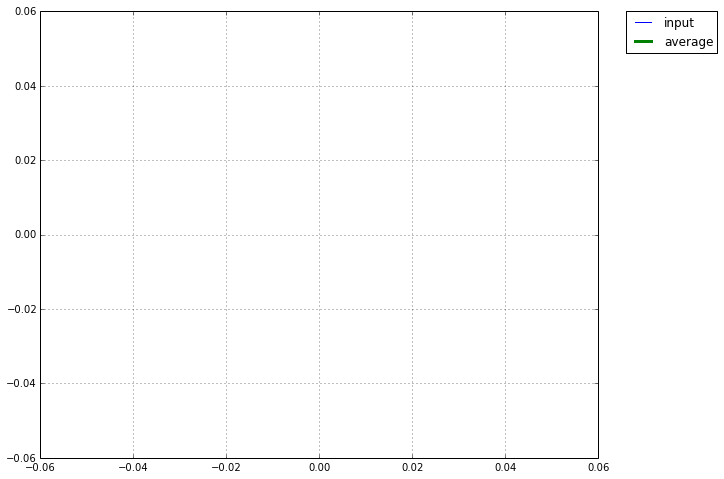

In [5]:
plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(A,label='input')
plt.plot(AV,linewidth=3.0,label='average')
#plt.plot(R,label='residual')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid()

**Suggested work** 

* Try different values of alpha
* Try using different types of signal (fixed mean, square wave, saw-tooth)

### Estimating the standard deviation

In [13]:
# This coroutine assumes that the input it recieves has mean zero
@coroutine
def std_filter(target,alpha=0):
    n=0; s=0
    while True:
        (a,av,r)=(yield) # wait here to be get something sent.
        if(alpha==0):  # regular average
            n+=1
            s+=r*r
            std=math.sqrt(s/n)
            sr=r/std  # a: input, sqrt(s/n): std, sr: rescaled residual
            target.send((a,av,r,std,sr))
        else:  # Exponentially decaying average
            s=alpha*(r*r)+(1-alpha)*s
            std=math.sqrt(s)
            sr=r/std
            target.send((a,av,r,std,sr))

In [18]:
sz=1000; scale=100.0
a=np.random.normal(loc=0,scale=1,size=sz) 
a= a+3*np.sin(np.arange(0,sz/scale,1/scale))
print len(a)

## 0.1 too large,  0.01 too small, 0.03 pretty good.
G=[]
Std=std_filter(collector(G),alpha=0.01)
Av=av_filter(Std,alpha=0.1)

for x in a:
    Av.send(x)

print len(G)

1000
1000


In [15]:
A=[]; AV=[]; R=[]; STD=[]; SR=[];
for (a,av,r,std,sr) in G:
    A.append(a)
    AV.append(av)
    R.append(r)
    STD.append(std)
    SR.append(sr)

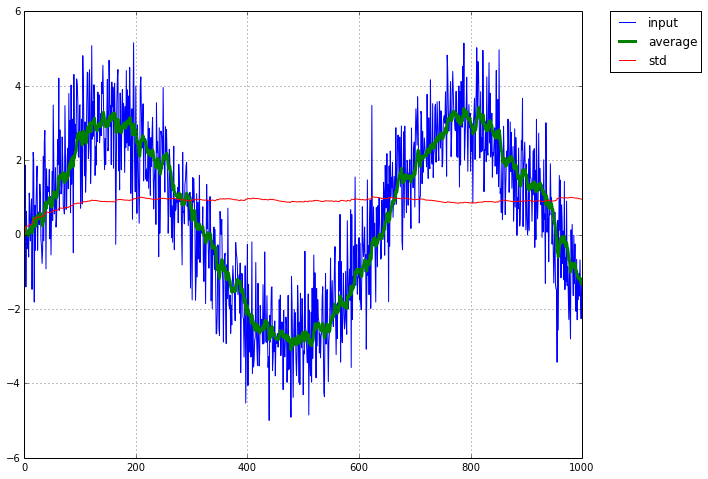

In [31] used 4.2891 MiB RAM in 0.39s, peaked 0.00 MiB above current, total RAM usage 94.26 MiB


In [31]:
plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(A,label='input')
plt.plot(AV,linewidth=3.0,label='average')
#plt.plot(R,label='residual')
plt.plot(STD,label='std')
#plt.plot(SR,label='scaled residual')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid()

**Suggested work** 

Leave the mean as it is and vary the standard deviation using a square wave. Observe what settings of alpha are needed for the average and for the std estimators.

## HW1

You will be given two files, each of 1-5GB and each consisting of a sequence of 64 bit floating point numbers. The files can be read using `numpy.fromfile()`

Your task is to write streaming algorithms that will calculate the mean and std of each sequence and the correlation coefficient between them. You should do that both on the sequence as a whole and on using an exponentially weighted average defined by a parameter $\alpha$.

Analyze the performance of your code on your computer, generate the appropriate figures to visualize performance 
and find good chunk sizes to use.

We will supply test files, you are encouraged to generate others.

Your notebook will also be run by the TA on his laptop, using data that will not be available to you. You code should work on that data.